In [1]:
!pip install -q sklearn
!pip install -q matplotlib

In [9]:
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import os
import io
from online_vectorizers import OnlineTfidfVectorizer
import scipy
import csv
import matplotlib.pyplot as plt
import pickle
import time

In [3]:
base_dir = 'dataset_parsed_new'

#primo file
filename = "00_total_no_stopwords.csv"
fname = os.path.join(base_dir, filename)
df = pd.read_csv(fname)

#classe custom di libreria che estende quello base di scikit-learn. Aggiunge il partial-refit
vectorizer = OnlineTfidfVectorizer()

#necessario per inizializzare il vocabolario del vectorizer per poi fare partial fitting
#attualmente refitta due volte sul primo documento ma dovrebbe essere idempotente, alla peggio si aggiunge una guardia nel for
vectorizer.fit(df["text"].apply(lambda x: np.str_(x)))


#fittiamo il dizionario del vectorizer con tutte le parole in tutti i file. Necessario un partial refit per non mettere
#tutti i 200 file in RAM. Prima passata.
def fit_vectorizer(corpus_path):
    corpus_path, dirs, files = next(os.walk(corpus_path))
    for f in files:
        print(f)
        try:
            data_path = os.sep.join([base_dir, f])
            document = pd.read_csv(data_path)
            vectorizer.partial_refit(document["text"].apply(lambda x: np.str_(x)))
            print("La dimensione del vocabolario è:" + str(len(vectorizer.vocabulary_)))
        except Exception as e:
            print(e)

c:\users\gabriele\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass input=content, encoding=utf-8, decode_error=strict, strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=(?u)\b\w\w+\b, ngram_range=(1, 1), analyzer=word, max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'> as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [4]:
fit_vectorizer(base_dir)
print("La dimensione del vocabolario è:" + str(len(vectorizer.vocabulary_)))
pickle.dump(vectorizer, open("vectorizer_new.pickle", "wb"))

00_total_no_stopwords.csv
La dimensione del vocabolario è:76804
01_total_no_stopwords.csv
La dimensione del vocabolario è:149918
02_total_no_stopwords.csv
La dimensione del vocabolario è:179209
03_total_no_stopwords.csv
La dimensione del vocabolario è:223845
04_total_no_stopwords.csv
La dimensione del vocabolario è:245720
05_total_no_stopwords.csv
La dimensione del vocabolario è:265009
06_total_no_stopwords.csv
La dimensione del vocabolario è:320760
07_total_no_stopwords.csv
La dimensione del vocabolario è:344412
08_total_no_stopwords.csv
La dimensione del vocabolario è:365931
09_total_no_stopwords.csv
La dimensione del vocabolario è:384316
0a_total_no_stopwords.csv
La dimensione del vocabolario è:397861
0b_total_no_stopwords.csv
La dimensione del vocabolario è:413057
0c_total_no_stopwords.csv
La dimensione del vocabolario è:426417
0d_total_no_stopwords.csv
La dimensione del vocabolario è:440673
0e_total_no_stopwords.csv
La dimensione del vocabolario è:453358
0f_total_no_stopwords.csv


La dimensione del vocabolario è:3422615
7e_total_no_stopwords.csv
La dimensione del vocabolario è:3425886
7f_total_no_stopwords.csv
La dimensione del vocabolario è:3430354
80_total_no_stopwords.csv
La dimensione del vocabolario è:3435001
81_total_no_stopwords.csv
La dimensione del vocabolario è:3447483
82_total_no_stopwords.csv
La dimensione del vocabolario è:3451276
83_total_no_stopwords.csv
La dimensione del vocabolario è:3458514
84_total_no_stopwords.csv
La dimensione del vocabolario è:3462102
85_total_no_stopwords.csv
La dimensione del vocabolario è:3465825
86_total_no_stopwords.csv
La dimensione del vocabolario è:3479912
87_total_no_stopwords.csv
La dimensione del vocabolario è:3486415
88_total_no_stopwords.csv
La dimensione del vocabolario è:3491333
89_total_no_stopwords.csv
La dimensione del vocabolario è:3494714
8a_total_no_stopwords.csv
La dimensione del vocabolario è:3499308
8b_total_no_stopwords.csv
La dimensione del vocabolario è:3503153
8c_total_no_stopwords.csv
La dimensi

La dimensione del vocabolario è:5321910
fb_total_no_stopwords.csv
La dimensione del vocabolario è:5325678
fc_total_no_stopwords.csv
La dimensione del vocabolario è:5328262
fd_total_no_stopwords.csv
La dimensione del vocabolario è:5345050
fe_total_no_stopwords.csv
La dimensione del vocabolario è:5348273
ff_total_no_stopwords.csv
La dimensione del vocabolario è:5351512
La dimensione del vocabolario è:5351512


In [5]:
#creiamo la matrice delle features andando a trasformare ogni file tramite il vectorizer. Necessaria questa seconda passata
#in quanto non è possibile farlo in parallelo a causa del vectorizer che è pronto solo alla fine della prima passata.

#Qua non è necessario un partial refit ma è necessario concatenare ogni matrice di ogni documento, in modo da crearne una totale
#La funzione per "concatenare" matrici (orizzontalmente come serve a noi in questo caso) è vstack. Utilizzo matrix come
#accumulatore e lo restituisco alla fine
def transform(corpus_path):
    corpus_path, dirs, files = next(os.walk(corpus_path))
    matrix = scipy.sparse.csr_matrix((0, len(vectorizer.vocabulary_)), dtype=None)
    for f in files:
        print(f)
        try:
            data_path = os.sep.join([base_dir, f])
            document = pd.read_csv(data_path)
            partial_matrix = vectorizer.transform(document["text"].apply(lambda x: np.str_(x)))
            print("La shape della matrice del documento attuale è: " + str(partial_matrix.shape))
            print("La shape della matrice totale prima è: " + str(matrix.shape))
            matrix = scipy.sparse.vstack([matrix,partial_matrix])
            print("La shape della matrice totale dopo l'unione è: " + str(matrix.shape))
        except Exception as e:
            print(e)
    return matrix

In [6]:
features_matrix = transform(base_dir)
print("La dimensione della matrice di features è:" + str(features_matrix.shape))
scipy.sparse.save_npz('features_matrix_on_documents_new', features_matrix)

00_total_no_stopwords.csv
La shape della matrice del documento attuale è: (10488, 5351512)
La shape della matrice totale prima è: (0, 5351512)
La shape della matrice totale dopo l'unione è: (10488, 5351512)
01_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12837, 5351512)
La shape della matrice totale prima è: (10488, 5351512)
La shape della matrice totale dopo l'unione è: (23325, 5351512)
02_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12878, 5351512)
La shape della matrice totale prima è: (23325, 5351512)
La shape della matrice totale dopo l'unione è: (36203, 5351512)
03_total_no_stopwords.csv
La shape della matrice del documento attuale è: (13119, 5351512)
La shape della matrice totale prima è: (36203, 5351512)
La shape della matrice totale dopo l'unione è: (49322, 5351512)
04_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12661, 5351512)
La shape della matrice totale prima è: (49322, 5351512)
La shape dell

La shape della matrice del documento attuale è: (12610, 5351512)
La shape della matrice totale prima è: (495150, 5351512)
La shape della matrice totale dopo l'unione è: (507760, 5351512)
28_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12663, 5351512)
La shape della matrice totale prima è: (507760, 5351512)
La shape della matrice totale dopo l'unione è: (520423, 5351512)
29_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12725, 5351512)
La shape della matrice totale prima è: (520423, 5351512)
La shape della matrice totale dopo l'unione è: (533148, 5351512)
2a_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12760, 5351512)
La shape della matrice totale prima è: (533148, 5351512)
La shape della matrice totale dopo l'unione è: (545908, 5351512)
2b_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12814, 5351512)
La shape della matrice totale prima è: (545908, 5351512)
La shape della matrice tot

La shape della matrice totale dopo l'unione è: (992067, 5351512)
4e_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12782, 5351512)
La shape della matrice totale prima è: (992067, 5351512)
La shape della matrice totale dopo l'unione è: (1004849, 5351512)
4f_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12749, 5351512)
La shape della matrice totale prima è: (1004849, 5351512)
La shape della matrice totale dopo l'unione è: (1017598, 5351512)
50_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12833, 5351512)
La shape della matrice totale prima è: (1017598, 5351512)
La shape della matrice totale dopo l'unione è: (1030431, 5351512)
51_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12881, 5351512)
La shape della matrice totale prima è: (1030431, 5351512)
La shape della matrice totale dopo l'unione è: (1043312, 5351512)
52_total_no_stopwords.csv
La shape della matrice del documento attuale è: (1

La shape della matrice del documento attuale è: (12909, 5351512)
La shape della matrice totale prima è: (1476507, 5351512)
La shape della matrice totale dopo l'unione è: (1489416, 5351512)
75_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12686, 5351512)
La shape della matrice totale prima è: (1489416, 5351512)
La shape della matrice totale dopo l'unione è: (1502102, 5351512)
76_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12749, 5351512)
La shape della matrice totale prima è: (1502102, 5351512)
La shape della matrice totale dopo l'unione è: (1514851, 5351512)
77_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12777, 5351512)
La shape della matrice totale prima è: (1514851, 5351512)
La shape della matrice totale dopo l'unione è: (1527628, 5351512)
78_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12838, 5351512)
La shape della matrice totale prima è: (1527628, 5351512)
La shape della ma

La shape della matrice totale dopo l'unione è: (1973752, 5351512)
9b_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12580, 5351512)
La shape della matrice totale prima è: (1973752, 5351512)
La shape della matrice totale dopo l'unione è: (1986332, 5351512)
9c_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12542, 5351512)
La shape della matrice totale prima è: (1986332, 5351512)
La shape della matrice totale dopo l'unione è: (1998874, 5351512)
9d_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12842, 5351512)
La shape della matrice totale prima è: (1998874, 5351512)
La shape della matrice totale dopo l'unione è: (2011716, 5351512)
9e_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12718, 5351512)
La shape della matrice totale prima è: (2011716, 5351512)
La shape della matrice totale dopo l'unione è: (2024434, 5351512)
9f_total_no_stopwords.csv
La shape della matrice del documento attuale è: 

La shape della matrice del documento attuale è: (12666, 5351512)
La shape della matrice totale prima è: (2458128, 5351512)
La shape della matrice totale dopo l'unione è: (2470794, 5351512)
c2_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12734, 5351512)
La shape della matrice totale prima è: (2470794, 5351512)
La shape della matrice totale dopo l'unione è: (2483528, 5351512)
c3_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12489, 5351512)
La shape della matrice totale prima è: (2483528, 5351512)
La shape della matrice totale dopo l'unione è: (2496017, 5351512)
c4_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12944, 5351512)
La shape della matrice totale prima è: (2496017, 5351512)
La shape della matrice totale dopo l'unione è: (2508961, 5351512)
c5_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12943, 5351512)
La shape della matrice totale prima è: (2508961, 5351512)
La shape della ma

La shape della matrice totale dopo l'unione è: (2956316, 5351512)
e8_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12546, 5351512)
La shape della matrice totale prima è: (2956316, 5351512)
La shape della matrice totale dopo l'unione è: (2968862, 5351512)
e9_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12741, 5351512)
La shape della matrice totale prima è: (2968862, 5351512)
La shape della matrice totale dopo l'unione è: (2981603, 5351512)
ea_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12630, 5351512)
La shape della matrice totale prima è: (2981603, 5351512)
La shape della matrice totale dopo l'unione è: (2994233, 5351512)
eb_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12705, 5351512)
La shape della matrice totale prima è: (2994233, 5351512)
La shape della matrice totale dopo l'unione è: (3006938, 5351512)
ec_total_no_stopwords.csv
La shape della matrice del documento attuale è: 

In [10]:
def load_matrix(filename='features_matrix_on_documents_new.npz'):
    return scipy.sparse.load_npz(filename)
features_matrix = load_matrix()

16:46:10 training 1 clusters kMeans
16:46:54 training 2 clusters kMeans
16:55:31 training 3 clusters kMeans
17:10:14 training 4 clusters kMeans
17:31:39 training 5 clusters kMeans
17:59:05 training 6 clusters kMeans
18:33:30 training 7 clusters kMeans
19:14:46 training 8 clusters kMeans
20:01:20 training 9 clusters kMeans


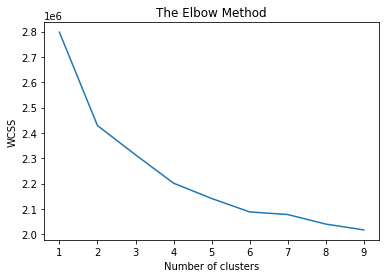

In [3]:
#Calcolo e plot dell'elbow method per capire il numero giusto di clusters. In ogni caso io farei con 5 ma facciamolo comunque.
wcss = []
for i in range(1, 10):
  print(f"{time.strftime('%H:%M:%S')} training {i} clusters kMeans")
  kmeans = KMeans(n_clusters = i, init='k-means++', random_state=42)
  kmeans.fit(features_matrix)
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow_method_new.png')
plt.show()

In [4]:
!pip install -q python-telegram-bot
from telegram import Bot
bot = Bot(token="**************************")
bot.send_message(text="Finito di trainare dataset completo", chat_id="141928344")

In [5]:
#DA SCOMMENTARE E RUNNARE DOPO AVER RUNNATO AL CELLA PRECEDENTE

true_k = 6 #da scegliere dopo aver runnato la cella precedente in base al grafico
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(features_matrix)
pickle.dump(model, open(f"new_kmeans_{true_k}.pkl", "wb"))


In [6]:
#DA RUNNARE PER FARE PREDICTIONS, SCOMMENTARE LE PRIME DUE RIGHE SE SI VUOLE CARICARE IL MODELLO E IL VECTORIZER

model = pickle.load(open(f"new_kmeans_{true_k}.pkl", "rb"))
vectorizer = pickle.load(open("vectorizer_new.pickle", "rb"))

#per stampare feature più utili dei centroidi/clusters
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
true_k = len(order_centroids)
terms = vectorizer.get_feature_names()
s = ""
for i in range(true_k):
 s += f"Cluster {i}:\n"
 for ind in order_centroids[i, :20]:
  s += f"{terms[ind]}\n"

with open(f"new_clusters_{true_k}.txt", "w") as f:
    f.write(s)
    



#PER FARE PREDICTIONS SUI DOCUMENTI NUOVI, INSERIRE IL DOCUMENTO ALLA RIGA 3
#print("\n")
#print("Prediction")
#prova = vectorizer.transform(#inserire un documento da testare)
#predicted = model.predict(prova)
#print(predicted)

In [7]:
print(s)

Cluster 0:
nan
public
gnu
general
license
software
copyright
version
see
terms
free
program
gpl
without
redistribute
debian
modify
package
published
licensed
Cluster 1:
license
apache
may
distributed
version
software
governing
limitations
language
obtain
file
compliance
permissions
required
agreed
except
law
applicable
unless
see
Cluster 2:
var
return
function
fa
public
string
navbar
import
end
def
class
else
ie
private
void
new
bold
default
nav
square
Cluster 3:
contributors
conditions
redistributions
copyright
binary
list
must
implied
source
following
provided
procurement
substitute
goods
strict
retain
materials
caused
theory
negligence
Cluster 4:
software
without
copyright
copies
permission
including
notice
shall
deal
furnished
dealings
persons
sell
obtaining
person
portions
substantial
action
permit
connection
Cluster 5:
work
derivative
program
license
source
may
terms
works
conditions
patent
mean
contributor
covered
licensor
object
notices
distribute
distribution
form
within



In [15]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
import pylab as pl
pca = TruncatedSVD(n_components=2).fit(features_matrix)
pca_2d = pca.transform(features_matrix)
#pl.figure('Reference Plot')
# pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=iris.target)


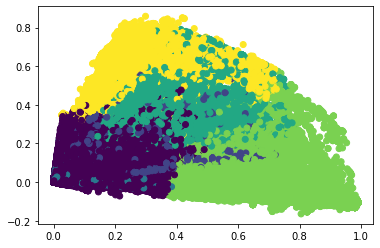

In [16]:
true_k = 6
kmeans = pickle.load(open(f"new_kmeans_{true_k}.pkl", "rb"))
pl.figure(f'K-means with {true_k} clusters')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
pl.savefig(f'k-means with {true_k} clusters.png')
pl.show()

In [ ]:
legend = []
for i in range(true_k):
    legend.append('Cluster {0}'.format(i))
pl.figure(f'K-means with {true_k} clusters')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
pl.legend()
pl.savefig(f'k-means with {true_k} clusters.png')
pl.show()

No handles with labels found to put in legend.


In [ ]:
!pip install -q python-telegram-bot
from telegram import Bot
bot = Bot(token="***************************************")
bot.send_message(text="Finito di salvare scatter plot", chat_id="141928344")